# COSC 4610/5610 Project 1 (spring 2022)

**Team members**: Jake Konrad, Max Steffen
jacob.konrad@marquette.edu, maxwell.steffen@marquette.edu

**Submission.** Please insert your names and emails above, save your code in this notebook, and explain what you are doing along with your findings in text cells. You can think of it as a technical report with code. Before submission, please use `Kernel -> Restart & Run All` in the Jupyter menu to verify your code is runnable and save all outputs. Afterwards, you can upload your raw notebook. 


In this project, we will practice with data cleaning and transformation methods on the California house sales data and check their effects on the price prediction model. The model training and the evaluation code will be given. Your job is to try different data pre-processing methods to obtain the best root mean squared logarithmic error (RMSLE) on the test dataset.


### Python 3 on Linux (Ubuntu and WSL)
If you need to install Python 3 in Ubuntu (and WSL), you can follow the steps
1. Start by updating the packages list and installing the prerequisites:

`sudo apt update`

`sudo apt install software-properties-common`

2. Next, add the deadsnakes PPA to your sources list:

`sudo add-apt-repository ppa:deadsnakes/ppa`

When prompted press Enter to continue:

Press [ENTER] to continue or Ctrl-c to cancel adding it.Copy

3. Once the repository is enabled, install, e.g., Python 3.9 with:

`sudo apt install python3.9`

If you are using Windows, you want to set up the WSL first (https://docs.microsoft.com/en-us/windows/wsl/install), install Python 3.9, and then run the jupyter server with the command `jupyter notebook --no-browser`. 

### Python 3 on Mac
Run the command `brew install python@3.9`. The binary should be on /usr/local/opt/python@3.9/bin/python3.9


### Virtualenv for multiple versions of Python
If you are using Linux (or WSL) and Mac with multiple versions of Python, the following method allows you to set up an isolated virtual environment, which does not interfere with your existing Python setups. 

1. run `python3 -m venv py39` to install the tool virtualenv. py39 is the directory that holds all packages specific to the virtual environment. You can choose whatever name you like.

2. run `source py39/bin/activate` to activate the py39 environment. You will see (py39) shows up in your command line prompt. You can run `deactivate` later to exit the virtual environment

3. after the virtual environment is activiated, install the necessary packages: `pip3 install notebook numpy pandas matplotlib`

4. run `jupyter notebook` and you are ready to use the python 3.9 environment and the installed packages in Jupyter.




## Prepare Data 

Download the data from http://www.cs.mu.edu/~keke/dm/data/house_sales.ftr. Note that we use the [`feather` format](https://arrow.apache.org/docs/python/feather.html), which is faster to read than CSV but uses more disk space. 
The following code needs at least 2GB memory. If using a local runtime, please make sure your machine has enough memory. 

In [235]:
from google.colab import files
uploads = files.upload()

In [236]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [237]:
# If the pacakges are not installed, run the following line once to install. You may need to restart your runtime afterwards:
import pandas as pd
import numpy as np

data = pd.read_feather('house_sales.ftr')
data.shape
print(data.head(20))


            Id                     Address   Sold Price   Sold On  \
0   2080183300             11205 Monterey,   $2,000,000  01/31/20   
1     20926300             5281 Castle Rd,   $2,100,000  02/25/21   
2     19595300            3581 Butcher Dr,   $1,125,000  11/06/19   
3    300472200       2021 N Milpitas Blvd,  $36,250,000  10/02/20   
4   2074492000   LOT 4 Tool Box Spring Rd,     $140,000  10/19/20   
5   2080638900  4707 La Villa Mari UNIT J,   $1,301,000  02/24/21   
6     19800000            7517 Deveron Ct,       $3,200  08/31/19   
7     20635000              3025 E 8th St,     $300,000  11/06/19   
8     20720300             1022 Manley Dr,     $795,000  01/30/21   
9     19522800          229 Del Monte Ave,   $1,750,000  08/31/18   
10    21438500           13821 Lanning Dr,     $556,000  01/13/21   
11    19759500      1318 Joplin Dr UNIT 3,     $470,000  12/18/20   
12    25182400           8155 Madison Ave,   $1,300,000  04/30/20   
13  2097430400         539 Tyrella

We select a few columns to demonstrate. You need to select more columns to make your model more accurate. 

In [238]:
# select a small number columns for demonstrating how to clean data and train models
columns = ['Sold Price', 'Sold On', 'Type', 'Year built', 'Bedrooms']


df = data[columns].copy()
# uncomment the below line to save memory
# del data
df.dtypes

Sold Price    object
Sold On       object
Type          object
Year built    object
Bedrooms      object
dtype: object

Data type "object" is the initial type when data is loaded in. We want to convert each to numeric and remove missing values and errors.

1. We convert `Sold Price` to numerical values, which is our prediction target. We also remove examples whose prices are too high or too low. For more examples, you can revisit the notebook https://www.cs.mu.edu/~keke/dm/house.ipynb.

In [239]:

c = 'Sold Price'
if c in df.select_dtypes('object').columns:
    df.loc[:,c] = np.log10(
            pd.to_numeric(df[c].replace(r'[$,-]', '', regex=True)) + 1) # replace the $ signs
    
df = df[(df['Sold Price'] >= 4 ) & (df['Sold Price'] <= 8 )] # use the prices between 10^4 and 10^8 only


2. Now handle "Type"

In [240]:
df['Type'].value_counts()

SingleFamily                                              100040
Condo                                                      26666
MultiFamily                                                 7189
Townhouse                                                   6818
Unknown                                                     5817
                                                           ...  
1 Level, Low-Rise (1-3), Unit Above, Ground Floor              1
Detached, 3 Story, Full                                        1
1 Level, Luxury, New Construction, Mid-Rise (4-8)              1
1 Level, Luxury, Low-Rise (1-3), End Unit                      1
Unit Below, Low-Rise (1-3), Full, Unit Above, Attached         1
Name: Type, Length: 317, dtype: int64

Let's only use the first four types of houses

In [241]:
df = df[df['Type'].isin(['SingleFamily', 'Condo', 'MultiFamily', 'Townhouse'])]
df['Type'].value_counts()

SingleFamily    100040
Condo            26666
MultiFamily       7189
Townhouse         6818
Name: Type, dtype: int64

In [242]:
# convert to categorical and then conver to integers
df['Type'] = df['Type'].astype('category').cat.codes
df['Type'].value_counts()

2    100040
0     26666
1      7189
3      6818
Name: Type, dtype: int64

In [243]:
# 3. handle "Year built"
df['Year built'].value_counts()

No Data    5821
1973       2212
2018       2161
1950       2096
2006       1959
           ... 
1650          1
1862          1
19            1
1571          1
1471          1
Name: Year built, Length: 180, dtype: int64

In [244]:
#remove "No Data"
df = df[df['Year built'] != 'No Data']
df['Year built'] = df['Year built'].astype('int')
# get rid of too old or irregular value 
df = df[(df['Year built']>1900)  & (df['Year built'] < 2023)]
df['Year built'].value_counts()

1973    2212
2018    2161
1950    2096
2006    1959
1955    1956
        ... 
1917     184
1903     168
1901     141
1902     140
2021      98
Name: Year built, Length: 121, dtype: int64

In [245]:
#4. handle "Bedrooms"
df['Bedrooms'].value_counts()

3                                                                                                                                                                    45514
2                                                                                                                                                                    28586
4                                                                                                                                                                    23194
1                                                                                                                                                                     6966
5                                                                                                                                                                     6801
                                                                                                                                                 

In [246]:
# we see a lot of noises; let's keep only the reasonable ones[0, 10] bedrooms
df  = df[df['Bedrooms'].isin([str(i) for i in range(11)])]
df['Bedrooms'] = df['Bedrooms'].astype('int')
df['Bedrooms'].value_counts()

3     45514
2     28586
4     23194
1      6966
5      6801
6      1723
0      1200
7       469
8       367
10      144
9       127
Name: Bedrooms, dtype: int64

In [247]:
df.shape # the number examples left so far

(115091, 5)

We use the house sales between 2021-2-15 and 2021-3-1 as our test data. You can use any example before 2021-2-15 for training, but not after. In other words, we pretend we are launching our model on 2021-2-15 and testing it for 2 weeks. Here we only use sales in 2021 for fast training.  

In [248]:

# split_data function can be used later before run modeling
def split_data(df, train_timestamp):
    # you can change the train_timestamp to include more training
    test_start, test_end = pd.Timestamp(2021, 2, 15), pd.Timestamp(2021, 3, 1)
    train_start = train_timestamp  
    df['Sold On'] = pd.to_datetime(df['Sold On'], errors='coerce')
    train = df[(df['Sold On'] >= train_start) & (df['Sold On'] < test_start)]
    test = df[(df['Sold On'] >= test_start) & (df['Sold On'] < test_end)]
    return train, test

# the following sample code include only 2021 data for training 
#train, test = split_data(df, pd.Timestamp(2021, 1, 1))
#train.shape, test.shape


In [249]:

# target is always "Sold Price"
# if you want to include more features, include them in the beginning and perform appropriate preprocessing.
# you can call the function prepare_train_test in your code

def prepare_train_test(train, test, features):
    target = "Sold Price"
    X_train = train.loc[:, features ]
    y_train = train.loc[:, [target]]
    X_test = test.loc[:, features]
    y_test = test.loc[:, [target]]
    return X_train, y_train, X_test, y_test

# for the demo program, we use only three features so far
features = ["Type", "Year built", 'Bedrooms'] 
#X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)


## Regression Baseline

We compute the baseline model with a gradient boosting regressor (GBM), which is a non-linear regression method. The specific implementation is called LightGBM. Details of modeling methods will be covered in later lectures. Thus, now we recommend that you reuse the following "modeling" function so that you can focus on data preprocessing. 

We use the root mean squared error (RMSE) to represent the prediction quality. With the few features, the baseline RMSE is around 0.26. We want to smaller RMSE as possible.

In [250]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

# define modeling function can be used later
def modeling (x_train, y_train, x_test, y_test):
    # training and test data as input
    print('Starting training...')
    # train
    gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=100)
    gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(5)])

    print('Starting predicting...')
    # predict
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
    # eval
    # use root mean squared error (RMSE)
    rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
    print(f'The RMSE of prediction is: {rmse_test}')
    return gbm


In [251]:

# get the training and testing split
train, test = split_data(df, pd.Timestamp(2021, 1, 1))

# use the selected features
features = ["Type", "Year built", 'Bedrooms'] 
X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)

# run modeling
predictor = modeling(X_train, y_train, X_test, y_test)

Starting training...
[1]	valid_0's l2: 0.0847723	valid_0's l2: 0.0847723
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0831737	valid_0's l2: 0.0831737
[3]	valid_0's l2: 0.0817374	valid_0's l2: 0.0817374
[4]	valid_0's l2: 0.0804391	valid_0's l2: 0.0804391
[5]	valid_0's l2: 0.079246	valid_0's l2: 0.079246
[6]	valid_0's l2: 0.0781672	valid_0's l2: 0.0781672
[7]	valid_0's l2: 0.0771731	valid_0's l2: 0.0771731
[8]	valid_0's l2: 0.0762974	valid_0's l2: 0.0762974
[9]	valid_0's l2: 0.0754931	valid_0's l2: 0.0754931
[10]	valid_0's l2: 0.0747553	valid_0's l2: 0.0747553
[11]	valid_0's l2: 0.07411	valid_0's l2: 0.07411
[12]	valid_0's l2: 0.0735063	valid_0's l2: 0.0735063
[13]	valid_0's l2: 0.0729728	valid_0's l2: 0.0729728
[14]	valid_0's l2: 0.0724833	valid_0's l2: 0.0724833
[15]	valid_0's l2: 0.0720351	valid_0's l2: 0.0720351
[16]	valid_0's l2: 0.0716198	valid_0's l2: 0.0716198
[17]	valid_0's l2: 0.0712279	valid_0's l2: 0.0712279
[18]	valid_0's l2: 0.0708709	val

Next, we compute the importance of each feature, along with several other metrics. It loooks like the `Sold On` feature is not very useful, likely because the houses in the test data were all sold late. You can choose to either remove such a feature, or find a way to extract a more useful presentation from it.

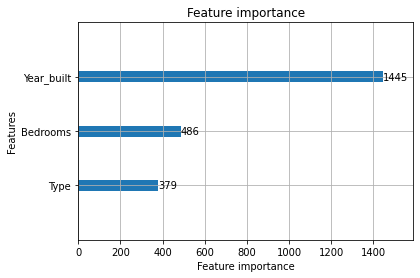

In [252]:
lgb.plot_importance(predictor)

## Your Tasks

Your goal is to train a model using the features in the original dataset that minimizes the RMSE on the validation dataset. While the naïve model achieves an RMS of ~0.26, it is possible to achieve an error of less than 0.08 on the same dataset (extra credit: +5, if you can find a VALID model with RMSE <0.1 :-) ).  

Complete the following tasks. 

1. Check examples in https://www.cs.mu.edu/~keke/dm/data/house.ipynb. Try more features. So far, we only selected a very small set of columns to use in training. You can add more, especially the ones that are intuitively useful, e.g., zip code, area, school district, garage space, etc. Try at least five more attributes. Report what you have done and what you have observed about the RMSE change. Do not include "Listed Price" as they may have considered z-estimate (the output of the prediction model). "Sold On" should not be used as future sales cannot utilize this information. 

2. Data cleaning: There are NAN and outliers sprinkled throughout the dataset. You should find ways to selectively filter and remove them. Summarize how you handle the missing values and outliers. Use one example to show how different strategies (e.g., removing NAN or replacing with some value) affect the final RMSE.

    Task 1 and 2 still use the training data from 2021 (as used in the above example). However, if the training or testing data size becomes too small (e.g., < 1000) due to data cleaning, the model quality assessment is not reliable. You may change the split_data code to get a larger testing data and adjust the covered period to get reasonable data size. 
    

3. Including more training examples: There is a large number of examples in previous years that you can also include. You may try different strategies to include more training data. However, alway keep the house sales between 2021-2-15 and 2021-3-1 as our test data. Reuse the "split_data" function with different time_stamps. The best set of features from the task 1&2 might be sufficiently good for this experiment. However, you may also check whether different sets of features may affect the modeling result. Describe what you do and report the RMSE change with different amount of training data (e.g., including the past 1 year, 2 years, ...). 


4. Finally, describe the best model you get: the features you used, data cleaning strategies, training data size, testing data size, RMSE, and the feature importance of the best model. 

Suggestion: reorganize the code neatly with functions to reuse pieces of code.

Rubrics: http://www.cs.mu.edu/~keke/dm/sp23/prj1-grading-temp.docx


**First Attempt:**
-------------------------------
RMSE VALUE OF 0.14890043804776348

In [253]:
# YOUR SOLUTION HERE
columns2 = ['Sold Price', 'Sold On', 'Type', 'Year built', 'Bedrooms','Cooling','Heating','Parking','HighSchoolDistrict','Zip']
df2 = data[columns2].copy()

df2.dtypes





Sold Price            object
Sold On               object
Type                  object
Year built            object
Bedrooms              object
Cooling               object
Heating               object
Parking               object
HighSchoolDistrict    object
Zip                   object
dtype: object

In [254]:
df2['Year built'] = df['Year built']
df2['Sold Price'] = df['Sold Price']
df2['Type'] = df['Type']
df2['Sold On'] = df['Sold On']
df2['Bedrooms'] = df['Bedrooms']
df2 = df2[df2['Zip'] != 'No Data']
df2 = df2[df2['Cooling'] != 'No Data']
df2 = df2[df2['Heating'] != 'No Data']
df2 = df2[df2['Parking'] != 'No Data']
df2 = df2[df2['HighSchoolDistrict'] != 'No Data']
df2 = df2[df2['Cooling'].isin(['None', 'Central Air', 'Central', 'Central AC','Other'])]
df2['Cooling'] = df2['Cooling'].astype('category').cat.codes
df2 = df2[df2['Heating'].isin(['Central', 'Forced air', 'Central Forced Air', 'Forced air, Gas'])]
df2['Heating'] = df2['Heating'].astype('category').cat.codes
df2 = df2[df2['Parking'].isin(['Garage, Garage - Attached, Covered','Garage - Attached', 'Garage', 'Garage, Garage - Attached', '0 spaces'])]
df2['Parking'] = df2['Parking'].astype('category').cat.codes
df2['HighSchoolDistrict'] = df2['HighSchoolDistrict'].astype('category').cat.codes
df2['Zip'] = df2['Zip'].astype('category').cat.codes


In [255]:
df2.head(100000)

,Sold Price,Sold On,Type,Year built,Bedrooms,Cooling,Heating,Parking,HighSchoolDistrict,Zip
5,6.114278,2021-02-24,3.0,1966.0,3.0,3,0,2,-1,101
6,NaN,NaT,NaN,NaN,NaN,0,3,4,-1,874
8,5.900368,2021-01-30,2.0,1939.0,2.0,2,0,1,-1,286
14,6.113944,2020-09-03,2.0,1962.0,4.0,4,1,4,-1,832
17,6.505150,2019-11-22,2.0,2019.0,5.0,0,0,4,-1,59
...,...,...,...,...,...,...,...,...,...,...
164924,5.688937,2020-12-11,2.0,2020.0,3.0,2,0,2,-1,587
164930,NaN,NaT,NaN,NaN,NaN,3,2,4,-1,868
164931,6.356982,2020-08-20,1.0,1992.0,4.0,3,3,4,-1,719
164937,5.537820,2021-02-03,0.0,1971.0,2.0,0,2,4,-1,756


In [256]:
df2.dtypes


Sold Price                   float64
Sold On               datetime64[ns]
Type                         float64
Year built                   float64
Bedrooms                     float64
Cooling                         int8
Heating                         int8
Parking                         int8
HighSchoolDistrict              int8
Zip                            int16
dtype: object

In [257]:
df2=df2.dropna(subset=['Sold Price', 'Sold On', 'Type', 'Year built', 'Bedrooms','Cooling','Heating','Parking','HighSchoolDistrict','Zip'])#, 'Zip', 'Cooling', 'Heating', 'Parking','HighSchoolDistrict'])
len(df2)

13033

In [258]:
train, test = split_data(df2, pd.Timestamp(2021, 1, 1))

<ipython-input-248-33cfc2a2c9ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sold On'] = pd.to_datetime(df['Sold On'], errors='coerce')


In [259]:

features = ['Type', 'Year built', 'Bedrooms','Cooling','Heating','Parking','HighSchoolDistrict','Zip']
X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)



In [260]:
predictor = modeling(X_train, y_train, X_test, y_test)

Starting training...
[1]	valid_0's l2: 0.0533033	valid_0's l2: 0.0533033
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0508033	valid_0's l2: 0.0508033
[3]	valid_0's l2: 0.048627	valid_0's l2: 0.048627
[4]	valid_0's l2: 0.0462923	valid_0's l2: 0.0462923
[5]	valid_0's l2: 0.0444066	valid_0's l2: 0.0444066
[6]	valid_0's l2: 0.0426789	valid_0's l2: 0.0426789
[7]	valid_0's l2: 0.0410491	valid_0's l2: 0.0410491
[8]	valid_0's l2: 0.0395722	valid_0's l2: 0.0395722
[9]	valid_0's l2: 0.0381934	valid_0's l2: 0.0381934
[10]	valid_0's l2: 0.0369389	valid_0's l2: 0.0369389
[11]	valid_0's l2: 0.0358384	valid_0's l2: 0.0358384
[12]	valid_0's l2: 0.0349699	valid_0's l2: 0.0349699
[13]	valid_0's l2: 0.0339468	valid_0's l2: 0.0339468
[14]	valid_0's l2: 0.0331794	valid_0's l2: 0.0331794
[15]	valid_0's l2: 0.0323383	valid_0's l2: 0.0323383
[16]	valid_0's l2: 0.0317001	valid_0's l2: 0.0317001
[17]	valid_0's l2: 0.0309553	valid_0's l2: 0.0309553
[18]	valid_0's l2: 0.0303521

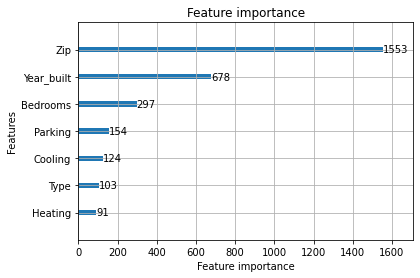

In [261]:
lgb.plot_importance(predictor)

**End Of First Attempt:**
FINAL RMSE VALUE OF 0.14890043804776348


**Second Attempt:**
----------------------------
RMSE VALUE OF 0.1716806776347261

In [262]:
columns3 = ['Sold Price', 'Sold On', 'Year built', 'Bedrooms','Cooling','Parking','Zip']
df3 = data[columns3].copy()

df3.dtypes



Sold Price    object
Sold On       object
Year built    object
Bedrooms      object
Cooling       object
Parking       object
Zip           object
dtype: object

In [263]:
df3['Year built'] = df['Year built']
df3['Sold Price'] = df['Sold Price']
df3['Sold On'] = df['Sold On']
df3['Bedrooms'] = df['Bedrooms']
df3 = df3[df3['Zip'] != 'No Data']
df3 = df3[df3['Cooling'] != 'No Data']
df3 = df3[df3['Parking'] != 'No Data']
df3 = df3[df3['Cooling'].isin(['None', 'Central Air', 'Central', 'Central AC','Other'])]
df3['Cooling'] = df3['Cooling'].astype('category').cat.codes
df3 = df3[df3['Parking'].isin(['Garage, Garage - Attached, Covered','Garage - Attached', 'Garage', 'Garage, Garage - Attached', '0 spaces'])]
df3['Parking'] = df3['Parking'].astype('category').cat.codes
df3['Zip'] = df3['Zip'].astype('category').cat.codes

df3.dtypes

Sold Price           float64
Sold On       datetime64[ns]
Year built           float64
Bedrooms             float64
Cooling                 int8
Parking                 int8
Zip                    int16
dtype: object

In [264]:
df3.fillna(0)

,Sold Price,Sold On,Year built,Bedrooms,Cooling,Parking,Zip
2,6.051153,2019-11-06 00:00:00,1954.0,3.0,1,4,1040
5,6.114278,2021-02-24 00:00:00,1966.0,3.0,3,2,105
6,0.000000,0,0.0,0.0,0,4,1075
8,5.900368,2021-01-30 00:00:00,1939.0,2.0,2,1,294
14,6.113944,2020-09-03 00:00:00,1962.0,4.0,4,4,1032
...,...,...,...,...,...,...,...
164926,5.944483,2020-07-16 00:00:00,1986.0,2.0,3,4,871
164930,0.000000,0,0.0,0.0,3,4,1069
164931,6.356982,2020-08-20 00:00:00,1992.0,4.0,3,4,879
164937,5.537820,2021-02-03 00:00:00,1971.0,2.0,0,4,921


In [265]:
train, test = split_data(df3, pd.Timestamp(2021, 1, 1))

In [266]:

features = ['Year built', 'Bedrooms','Cooling','Parking','Zip']
X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)



In [267]:
predictor = modeling(X_train, y_train, X_test, y_test)

Starting training...
[1]	valid_0's l2: 0.0601105	valid_0's l2: 0.0601105
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0574751	valid_0's l2: 0.0574751
[3]	valid_0's l2: 0.0550287	valid_0's l2: 0.0550287
[4]	valid_0's l2: 0.052883	valid_0's l2: 0.052883
[5]	valid_0's l2: 0.0509277	valid_0's l2: 0.0509277
[6]	valid_0's l2: 0.0492364	valid_0's l2: 0.0492364
[7]	valid_0's l2: 0.0475823	valid_0's l2: 0.0475823
[8]	valid_0's l2: 0.046188	valid_0's l2: 0.046188
[9]	valid_0's l2: 0.0450066	valid_0's l2: 0.0450066
[10]	valid_0's l2: 0.0437922	valid_0's l2: 0.0437922
[11]	valid_0's l2: 0.0426648	valid_0's l2: 0.0426648
[12]	valid_0's l2: 0.0417755	valid_0's l2: 0.0417755
[13]	valid_0's l2: 0.0409416	valid_0's l2: 0.0409416
[14]	valid_0's l2: 0.040294	valid_0's l2: 0.040294
[15]	valid_0's l2: 0.0396172	valid_0's l2: 0.0396172
[16]	valid_0's l2: 0.0389921	valid_0's l2: 0.0389921
[17]	valid_0's l2: 0.0384665	valid_0's l2: 0.0384665
[18]	valid_0's l2: 0.0379425	val

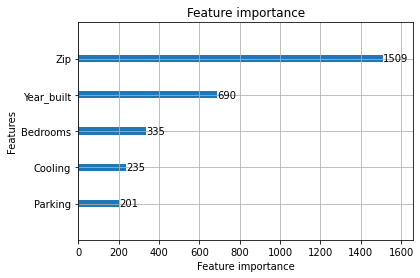

In [268]:
lgb.plot_importance(predictor)

**End Of Second Attempt:**
FINAL RMSE VALUE OF 0.1716806776347261

**Third Attempt:**
----------------------------
RMSE VALUE OF 0.1508279943760018


In [269]:
columns3 = ['Sold Price', 'Sold On', 'Type', 'Year built', 'Bedrooms','Cooling','Heating','Parking','HighSchoolDistrict','Zip']
df4 = data[columns3].copy()

df4.dtypes

Sold Price            object
Sold On               object
Type                  object
Year built            object
Bedrooms              object
Cooling               object
Heating               object
Parking               object
HighSchoolDistrict    object
Zip                   object
dtype: object

In [270]:
df4['Year built'] = df['Year built']
df4['Sold Price'] = df['Sold Price']
df4['Type'] = df['Type']
df4['Sold On'] = df['Sold On']
df4['Bedrooms'] = df['Bedrooms']
df4 = df4[df4['Zip'] != 'No Data']
df4 = df4[df4['Cooling'] != 'No Data']
df4 = df4[df4['Heating'] != 'No Data']
df4 = df4[df4['Parking'] != 'No Data']
df4 = df4[df4['HighSchoolDistrict'] != 'No Data']
df4 = df4[df4['Cooling'].isin(['None', 'Central Air', 'Central', 'Central AC','Other'])]
df4['Cooling'] = df4['Cooling'].astype('category').cat.codes
df4 = df4[df4['Heating'].isin(['Central', 'Forced air', 'Central Forced Air', 'Forced air, Gas'])]
df4['Heating'] = df4['Heating'].astype('category').cat.codes
df4 = df4[df4['Parking'].isin(['Garage, Garage - Attached, Covered','Garage - Attached', 'Garage', 'Garage, Garage - Attached', '0 spaces'])]
df4['Parking'] = df4['Parking'].astype('category').cat.codes
df4['HighSchoolDistrict'] = df4['HighSchoolDistrict'].astype('category').cat.codes
df4['Zip'] = df4['Zip'].astype('category').cat.codes

df4.dtypes

Sold Price                   float64
Sold On               datetime64[ns]
Type                         float64
Year built                   float64
Bedrooms                     float64
Cooling                         int8
Heating                         int8
Parking                         int8
HighSchoolDistrict              int8
Zip                            int16
dtype: object

In [271]:
df4.fillna(0)

,Sold Price,Sold On,Type,Year built,Bedrooms,Cooling,Heating,Parking,HighSchoolDistrict,Zip
5,6.114278,2021-02-24 00:00:00,3.0,1966.0,3.0,3,0,2,-1,101
6,0.000000,0,0.0,0.0,0.0,0,3,4,-1,874
8,5.900368,2021-01-30 00:00:00,2.0,1939.0,2.0,2,0,1,-1,286
14,6.113944,2020-09-03 00:00:00,2.0,1962.0,4.0,4,1,4,-1,832
17,6.505150,2019-11-22 00:00:00,2.0,2019.0,5.0,0,0,4,-1,59
...,...,...,...,...,...,...,...,...,...,...
164924,5.688937,2020-12-11 00:00:00,2.0,2020.0,3.0,2,0,2,-1,587
164930,0.000000,0,0.0,0.0,0.0,3,2,4,-1,868
164931,6.356982,2020-08-20 00:00:00,1.0,1992.0,4.0,3,3,4,-1,719
164937,5.537820,2021-02-03 00:00:00,0.0,1971.0,2.0,0,2,4,-1,756


In [272]:
train, test = split_data(df4, pd.Timestamp(2020, 4, 1))

In [273]:

features = ['Type', 'Year built', 'Bedrooms','Cooling','Heating','Parking','HighSchoolDistrict','Zip']
X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)

In [274]:
predictor = modeling(X_train, y_train, X_test, y_test)

Starting training...
[1]	valid_0's l2: 0.0594682	valid_0's l2: 0.0594682
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0560485	valid_0's l2: 0.0560485
[3]	valid_0's l2: 0.0529832	valid_0's l2: 0.0529832
[4]	valid_0's l2: 0.0502172	valid_0's l2: 0.0502172
[5]	valid_0's l2: 0.0475985	valid_0's l2: 0.0475985
[6]	valid_0's l2: 0.0454665	valid_0's l2: 0.0454665
[7]	valid_0's l2: 0.043287	valid_0's l2: 0.043287
[8]	valid_0's l2: 0.0412656	valid_0's l2: 0.0412656
[9]	valid_0's l2: 0.0396341	valid_0's l2: 0.0396341
[10]	valid_0's l2: 0.0380474	valid_0's l2: 0.0380474
[11]	valid_0's l2: 0.0366388	valid_0's l2: 0.0366388
[12]	valid_0's l2: 0.0353175	valid_0's l2: 0.0353175
[13]	valid_0's l2: 0.0341871	valid_0's l2: 0.0341871
[14]	valid_0's l2: 0.0331819	valid_0's l2: 0.0331819
[15]	valid_0's l2: 0.032329	valid_0's l2: 0.032329
[16]	valid_0's l2: 0.0316105	valid_0's l2: 0.0316105
[17]	valid_0's l2: 0.0308891	valid_0's l2: 0.0308891
[18]	valid_0's l2: 0.0302557	v

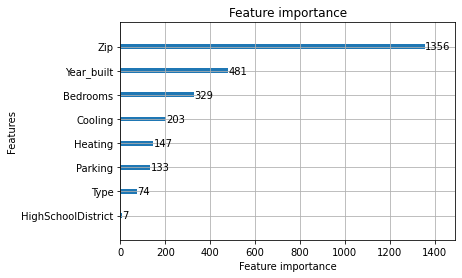

In [275]:
lgb.plot_importance(predictor)

**End Of Third Attempt:**
FINAL RMSE VALUE OF 0.1508279943760018


**Fourth Attempt:**
----------------------------
RMSE VALUE OF 0.19101312026171277


In [276]:
columns5 = ['Sold Price', 'Sold On', 'Type', 'Year built', 'Bedrooms','Zip','Flooring']
df5 = data[columns5].copy()



In [277]:
df5['Year built'] = df['Year built']
df5['Sold Price'] = df['Sold Price']
df5['Type'] = df['Type']
df5['Sold On'] = df['Sold On']
df5['Bedrooms'] = df['Bedrooms']
df5 = df5[df5['Zip'] != 'No Data']
df5['Zip'] = df5['Zip'].astype('category').cat.codes
df5['Flooring'] = df5['Flooring'].astype('category').cat.codes
len(df5)

164944

In [278]:
df5=df5.dropna(subset=['Sold Price'])

mean_value=df5['Type'].mean()
df5['Type'].fillna(value=mean_value, inplace=True)

mean_value=df5['Year built'].mean()
df5['Year built'].fillna(value=mean_value, inplace=True)

mean_value=df5['Bedrooms'].mean()
df5['Bedrooms'].fillna(value=mean_value, inplace=True)

mean_value=df5['Zip'].mean()
df5['Zip'].fillna(value=mean_value, inplace=True)

mean_value=df5['Flooring'].mean()
df5['Flooring'].fillna(value=mean_value, inplace=True)

df5=df5.dropna(subset=['Sold On'])

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [279]:
len(df5)

115091

In [280]:
train, test = split_data(df5, pd.Timestamp(2020, 1, 1))

In [281]:
features = ['Type', 'Year built', 'Bedrooms','Zip','Flooring']
X_train, y_train, X_test, y_test = prepare_train_test(train, test, features)

In [282]:
predictor = modeling(X_train, y_train, X_test, y_test)

Starting training...
[1]	valid_0's l2: 0.0842382	valid_0's l2: 0.0842382
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0805137	valid_0's l2: 0.0805137
[3]	valid_0's l2: 0.0770614	valid_0's l2: 0.0770614
[4]	valid_0's l2: 0.0743552	valid_0's l2: 0.0743552
[5]	valid_0's l2: 0.0718488	valid_0's l2: 0.0718488
[6]	valid_0's l2: 0.0691368	valid_0's l2: 0.0691368
[7]	valid_0's l2: 0.0671653	valid_0's l2: 0.0671653
[8]	valid_0's l2: 0.0646457	valid_0's l2: 0.0646457
[9]	valid_0's l2: 0.0630227	valid_0's l2: 0.0630227
[10]	valid_0's l2: 0.0612709	valid_0's l2: 0.0612709
[11]	valid_0's l2: 0.0598032	valid_0's l2: 0.0598032
[12]	valid_0's l2: 0.0581772	valid_0's l2: 0.0581772
[13]	valid_0's l2: 0.056531	valid_0's l2: 0.056531
[14]	valid_0's l2: 0.0554788	valid_0's l2: 0.0554788
[15]	valid_0's l2: 0.054537	valid_0's l2: 0.054537
[16]	valid_0's l2: 0.0532727	valid_0's l2: 0.0532727
[17]	valid_0's l2: 0.0521159	valid_0's l2: 0.0521159
[18]	valid_0's l2: 0.0512167	v

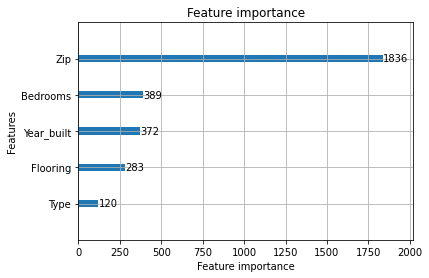

In [283]:
lgb.plot_importance(predictor)

**End Of Fourth Attempt:**
FINAL RMSE VALUE OF 0.19101312026171277


**Final Summary:**
----------------------------

In our first attempt at this experiment, all we did was add five more categories to the data frame used to create the train and test data. These categories included Cooling, Heating, Parking, HighSchoolDistrict, and Zipcode. Since most of these were categorical data, we had to convert the values into integer or float types. We first categorized the data and only kept the values in the data frame that were in the top 5 or 6 categories for every column. For example, there were thousands of data entries where the cooling system was that of "Central Air" so we deicded to keep those entries and remove entries whose cooling system was only present a handful of times. After doing this, we converted every category into an integer value ussually ranging 1-6 in order to be able to use that data for later RMSE testing. We then removed any rows that had an NA value in any column, leaving 13,033 entries that we deemed usable for RMSE testing. Hence, we began the RMSE test with the standard split data time stamp of 1/1/2021. The program calculated an RMSE value of aprox. 0.15 which is over .1 less than the starting RMSE value. However, we still wanted to branch out and do what we could to acheive an even lower RMSE value.

The next two attempts we did were experiments of different methods of data cleaning and column adding in order to make our predictor better and output a lower RMSE value. In attempt two, we only included columns Sold Price, Sold On, Year built, Bedrooms, Cooling, Parking, and Zip as our graph in attempt one showed that those columns were the most helpful in training our predictor. We also filled every NA value in every row with 0 instead of removing the rows all together. These methods allowed us to have 37800 rows of data instead of the 13033 rows of data we had in our first attempt. Sadly, even with these new methods of data cleaning, we recieved an RMSE value of 0.1716806776347261, which was lower than what we recieved in our first attempt.

Saddened by the outcome, we decided to keep attempt three much simpler and only change two things from the first attempt. All we did was change every NA value in every row to 0 and set the timestamp to 4/1/2020. This left us with 17531 rows of data to work with. We were then presented with an RMSE value of
0.1508279943760018. While this value was lower than that in our second attempt, it still is not the best RMSE value we obtained.

In attempt four, we did many different versions of data cleaning. We only contained columns Sold Price, Sold On, Year built, Bedrooms, Zip, and Flooring. Including flooring allowed for a new column of data which contained over 2,000 non-estimated values. We then filled every column's NA values, except for Sold Price and and Sold On, with the average value of the column. We then removed every row that contained an NA value in either column Sold Price or Sold On. We also changed the timestamp for the predicitor to 4/1/2020. This left us with 115091 full rows of data for our predictor to use to learn. However, even after all of our attempts at data cleaning, we were left with an RMSE value of 
0.19101312026171277, our worst so far.

In the end, this project taught us both a lot about data cleaning and that too much data cleaning can sometimes be a bad thing. We also learned many python coding tricks such as categorizing values in a data frame column and changing NA values in a column into the average of the columns other values. While we were unable to produce an RMSE value lower than 0.1, we were proud to have lowered the original RMSE by as much as we did. Starting from an RMSE value of 0.25932023967250384 and ending with an RMSE value 0.14890043804776348 is definetly nothing to be ashamed of, even if a lot of our attempts to further lower the RMSE value were unsuccesful.

**Credits**
----------------------------
Project completed by Max Steffen and Jake Konrad on 2/19/2023 over the span of two weeks.

Special thanks to Keke Chen for assisting us along the way.